### Global Libraries

In [1841]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from matplotlib.pyplot import figure
import numpy.matlib
from scipy.optimize import minimize

#### Reading the file and transforming data (1.1 - 1.2)

In [2321]:
# Reading games data
dataset = pd.read_csv("USA.csv")
# Reading conference data created to merge in games
conference = pd.read_csv("conference.csv")

# Merging conference in games dataset
dataset = pd.merge(dataset, conference[['Team', 'Conference']], left_on='Home', right_on='Team')
dataset.rename(columns = {'Conference': 'home_conference'}, inplace=True)\

dataset = pd.merge(dataset, conference[['Team', 'Conference']], left_on='Away', right_on='Team')
dataset.rename(columns = {'Conference': 'away_conference'}, inplace=True)

dataset = dataset.drop(columns=['Country', 'League', 'Team_x', 'Team_y'])
# dataset.head(5)

# Python readable date format for filtering in the next steps
dataset['Date'] = pd.to_datetime(dataset['Date'], format="%d/%m/%Y")
dataset['total_goals'] = dataset['HG'] + dataset['AG']

# Creating trainin set
fitset = dataset[(dataset.Date > '01/01/2012') & (dataset.Date <= '12/06/2015')]
# Creating Test set
simset = dataset[(dataset.Date > '12/06/2015') & (dataset.Date <= '10/23/2016')]

### 2 Descriptive Statistics

#### 2.1 - Percentage of matches where teams belong to different  Conferences

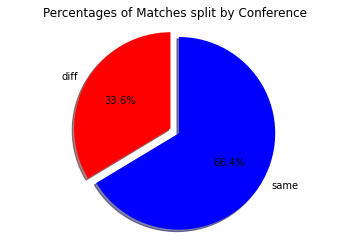

The percentage of teams belonging to different conferences is : 33.63


In [1922]:
# fitset.head()
fitset_size = len(fitset)
# Calculating number of Teams in different conferences
diff_conference = len(fitset[fitset.home_conference != fitset.away_conference])

# Plotting a Pie chart to represent the same
labels = ['diff', 'same']
sizes = [diff_conference, fitset_size - diff_conference]
colors = ['red', 'blue']
explode = (0, 0.1)
plt.pie(sizes, explode = explode,labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Percentages of Matches split by Conference')
plt.show()
print("The percentage of teams belonging to different conferences is :", np.round((diff_conference/fitset_size)*100,2))

#### 2.2 Statistical Significance of Home advantage between the 2 Conferences

Home:
home_conference
Eastern    0.536585
Western    0.512015
dtype: float64


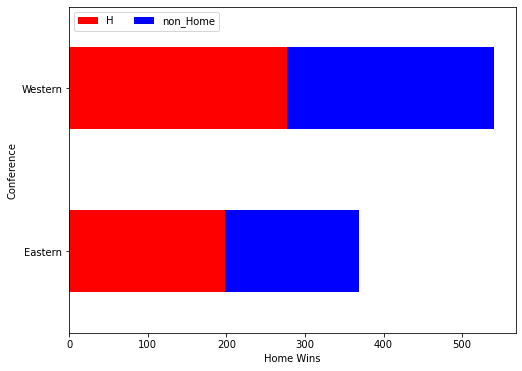

The value of the test statistic is 0.5307780051778278. The p-value is: 0.466279953528816


In [1850]:
# Creating a contengency Table to apply a Chi Squared Statistical Test
same_conf = fitset[(fitset.home_conference == fitset.away_conference)]
grouped_table = pd.crosstab(index=same_conf.home_conference, columns=same_conf.Res)
# print(grouped_table)
home_ratio = grouped_table["H"]/grouped_table.sum(axis=1)

grouped_table['non_Home'] = grouped_table['D'] + grouped_table['A']
grouped_table = grouped_table.drop(columns=['D', 'A'])

# applying a chi test on the contengency table to get the significance of the difference of Home wins per conference
chi2, p_val, dof, exp_counts = stats.chi2_contingency(grouped_table, correction=False)

# Plotting grouped table as a Horizontal bar plot to show the ratio of Home matches won to total matches in each conference
grouped_table.plot(kind='barh', stacked=True, color=['red', 'blue'], figsize=(8, 6))

print("Home:")
print(home_ratio)
plt.legend(loc="upper left", ncol=2)
plt.ylabel("Conference")
plt.xlabel("Home Wins")
plt.title("")
plt.show()
print("The value of the test statistic is "+str(chi2)+". The p-value is: "+str(p_val))

For the matches between teams in the same conference, The Eastern conference has a home win percentage of 53.65%(148 Home games won out of 265) and the Western conference has a Home win percentage of 51.2%(277 Home games won out of 541)

Our Null Hypothesis is that the difference in Home advantage between Eastern and Western conference is not significant.

Using Chi Squared test to test if the difference is statistically significant, also taking into account the number of games, we get a p-value of 0.466. If we operate at a significance level of 0.1, the p-value is above that significance level, hence failing to reject the null hypothesis and denoting the difference is not statistically significant. 

#### 2.3 Seasonality in the Data

Finding the trend and seasonality in the average goals scored per month every year

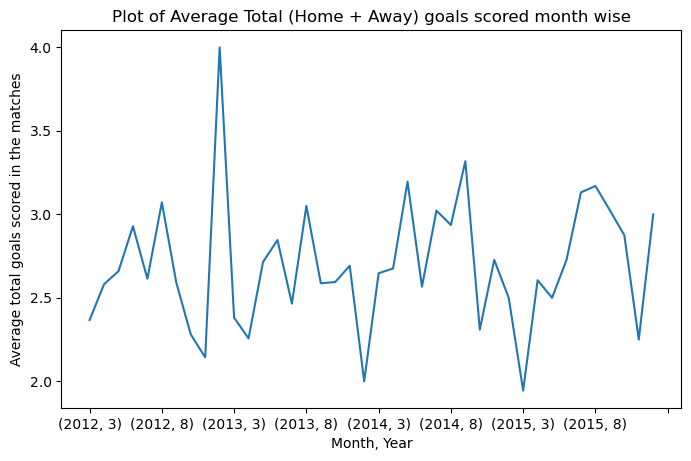

Text(0.5, 1.0, 'Plot of Average Total (Home + Away) goals scored month wise')

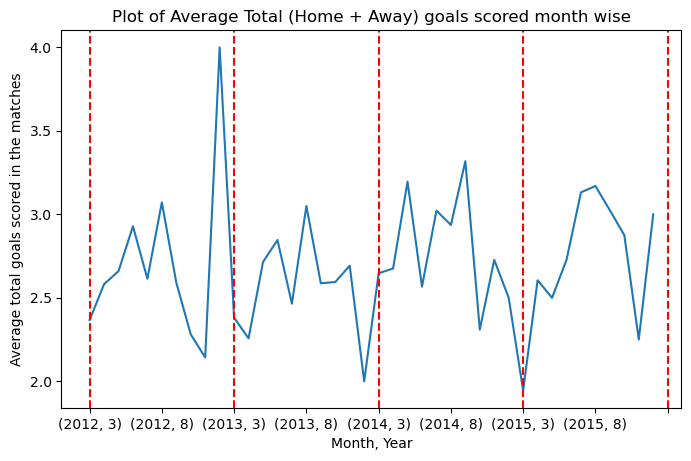

In [1926]:
group_month_year = fitset.groupby([fitset['Date'].dt.year,fitset['Date'].dt.month]).apply(lambda x: x['total_goals'].sum()/len(x))
figure(figsize = (8, 5), dpi = 100)
group_month_year.plot()
plt.ylabel("Average total goals scored in the matches")
plt.xlabel("Month, Year")
plt.title("Plot of Average Total (Home + Away) goals scored month wise")
plt.show()

figure(figsize = (8, 5), dpi = 100)
group_month_year.plot()
for i in np.arange(0,group_month_year.size+1,10): # +1 has been added to get a line at 72; recall the way arange works
    plt.axvline(i,color='r',linestyle='--')
plt.ylabel("Average total goals scored in the matches")
plt.xlabel("Month, Year")
plt.title("Plot of Average Total (Home + Away) goals scored month wise")



Finding the trend in the data and plotting it with the original average goals scored per month.

Mean Value of the trend is: 2.698759566567733


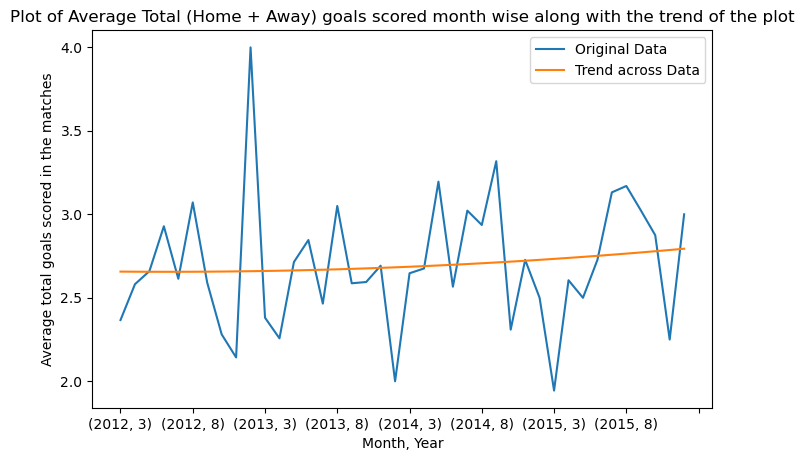

In [1929]:
size = group_month_year.size
coefficients = np.polyfit(np.arange(0,size),group_month_year,2)
arguments = np.concatenate((np.arange(size).reshape(size,1)**2,np.arange(size).reshape(size,1),np.ones(size).reshape(size,1)),axis = 1)

# Finding the trend plot with an order 2 equation
trend = arguments @ coefficients
print("Mean Value of the trend is:", np.mean(trend))

# plt.plot(x)
figure(figsize = (8, 5), dpi = 100)

group_month_year.plot()
plt.plot(trend)

plt.title("Plot of Average Total (Home + Away) goals scored month wise along with the trend of the plot")
plt.ylabel("Average total goals scored in the matches")
plt.xlabel("Month, Year")
plt.legend(['Original Data','Trend across Data'])


Subtracting the trend, we get de-trended series

Text(0.5, 1.0, 'Average Total goals scored in the matches without trend')

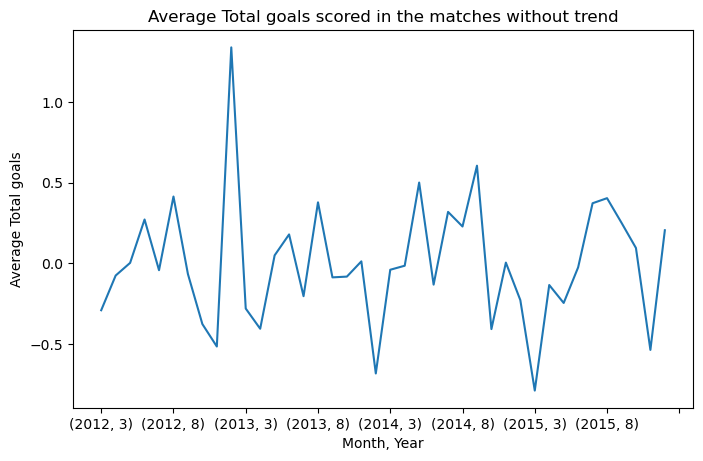

In [1930]:
xNoTrend = group_month_year-trend
# plt.plot(xNoTrend)
figure(figsize = (8, 5), dpi = 100)


xNoTrend.plot()
plt.ylabel("Average Total goals")
plt.xlabel("Month, Year")
plt.title("Average Total goals scored in the matches without trend")

Seasonality

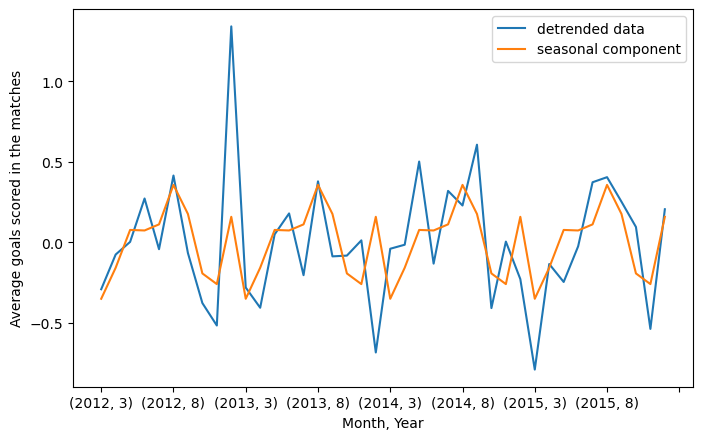

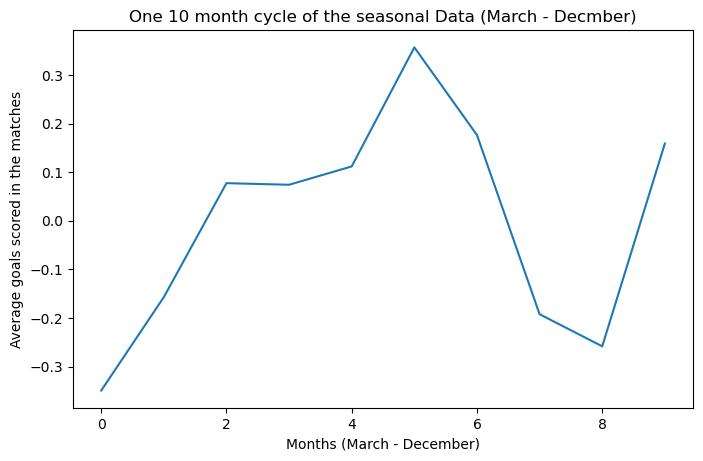

In [1931]:
z = np.array(xNoTrend)
wave = np.mean(z.reshape(int(z.size/10),10),axis=0)

# Finding the seasonal component of the data
seasonal = np.matlib.repmat(wave,1,4)
seasonal = np.transpose(seasonal) # this makes seasonal the same shape as x 
seasonal.shape

figure(figsize = (8, 5), dpi = 100)
xNoTrend.plot()
plt.ylabel("Average goals scored in the matches")
plt.xlabel("Month, Year")

plt.plot(seasonal)
plt.legend(('detrended data','seasonal component'))
plt.show()

figure(figsize = (8, 5), dpi = 100)
plt.title("One 10 month cycle of the seasonal Data (March - Decmber)")
plt.ylabel("Average goals scored in the matches")
plt.xlabel("Months (March - December)")
plt.plot(seasonal[0:10])

# print(seasonal[0:10])

We see that 0 is the month of March in this one seasonal cycle and 5 is August where the goals peak.

August is typically the middle of the season, when teams have had time to settle into their playing styles and players have become more accustomed to playing together. This can lead to more cohesive team performances and more goals being scored.
Secondly, the weather conditions in August can be favorable for scoring goals. In many parts of the United States and Canada, August is a hot and humid month, which can tire out defenders and make it easier for attackers to find space and create scoring opportunities.
Finally, the schedule of games in August often includes a number of matches between teams that are fighting for playoff positions. These high-stakes games can lead to more attacking play and a greater willingness to take risks in search of goals.

A possible reason why we see the lowest scoring games in March is : 
Firstly, March is the beginning of the season, and teams may still be working on building their chemistry and settling into their playing style. This can lead to more cautious play and fewer goals being scored. Additionally, the weather conditions in March can be less favorable for attacking play, with colder temperatures and, in some regions, inclement weather that can affect the quality of play.
The MLS schedule tends to include a number of international breaks in March and December, when players are called up to play for their national teams in various competitions. This can lead to disruptions in team chemistry and a lack of continuity in the starting lineups, which can in turn affect the number of goals being scored.

November is a low scoring month since the playoffs are a high-pressure situation, and teams tend to focus more on defense rather than offense. The teams know that even one goal conceded can be the difference between advancing to the next round or being eliminated. Therefore, teams are more cautious and tend to play more defensively, which can result in lower-scoring games.

##### Finding the trend and seasonality in Home Goals and Away goals of the training set in a similar manner

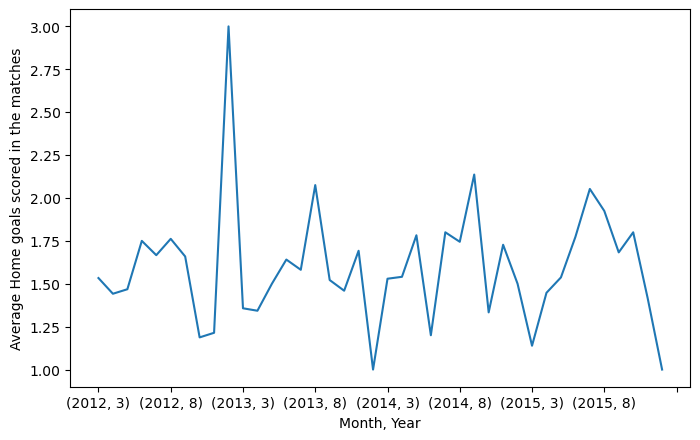

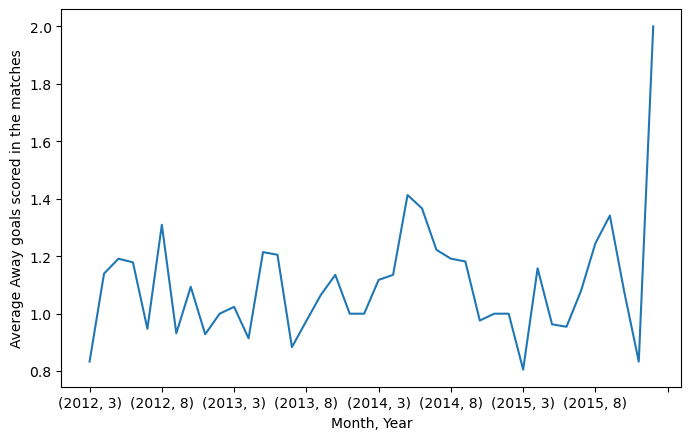

In [1456]:
# Home goal plot per month
group_month_year_home = fitset.groupby([fitset['Date'].dt.year,fitset['Date'].dt.month]).apply(lambda x: x['HG'].sum()/len(x))
figure(figsize = (8, 5), dpi = 100)
group_month_year_home.plot()
plt.ylabel("Average Home goals scored in the matches")
plt.xlabel("Month, Year")
plt.show()

# Away goal plot per month
group_month_year_away = fitset.groupby([fitset['Date'].dt.year,fitset['Date'].dt.month]).apply(lambda x: x['AG'].sum()/len(x))
figure(figsize = (8, 5), dpi = 100)
group_month_year_away.plot()
plt.ylabel("Average Away goals scored in the matches")
plt.xlabel("Month, Year")
plt.show()

Mean Value of the Home trend is: 1.598016019356312
Mean Value of the Away trend is: 1.1007435472114206


Text(0.5, 0, 'Month, Year')

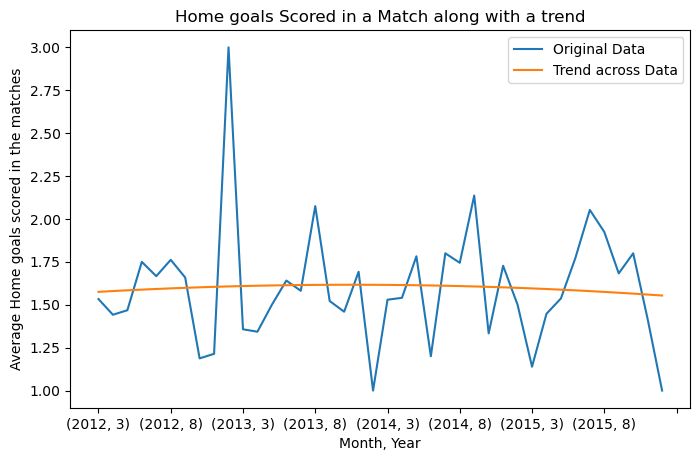

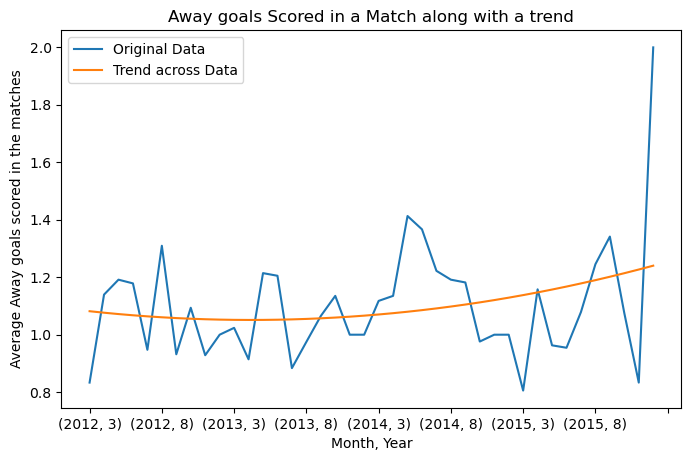

In [1932]:
# Finding the trend of Home goals data of Training set
size = group_month_year_home.size
coefficients = np.polyfit(np.arange(0,size),group_month_year_home,2)
arguments = np.concatenate((np.arange(size).reshape(size,1)**2,np.arange(size).reshape(size,1),np.ones(size).reshape(size,1)),axis = 1)
trend_home = arguments @ coefficients
print("Mean Value of the Home trend is:", np.mean(trend_home))

figure(figsize = (8, 5), dpi = 100)
group_month_year_home.plot()
plt.plot(trend_home)
plt.legend(['Original Data','Trend across Data'])
plt.title("Home goals Scored in a Match along with a trend")
plt.ylabel("Average Home goals scored in the matches")
plt.xlabel("Month, Year")


# Finding the trend of Away goals data of Training set
size = group_month_year_away.size
coefficients = np.polyfit(np.arange(0,size),group_month_year_away,2)
arguments = np.concatenate((np.arange(size).reshape(size,1)**2,np.arange(size).reshape(size,1),np.ones(size).reshape(size,1)),axis = 1)
trend_away = arguments @ coefficients
print("Mean Value of the Away trend is:", np.mean(trend_away))


figure(figsize = (8, 5), dpi = 100)
group_month_year_away.plot()
plt.plot(trend_away)
plt.legend(['Original Data','Trend across Data'])
plt.title("Away goals Scored in a Match along with a trend")
plt.ylabel("Average Away goals scored in the matches")
plt.xlabel("Month, Year")


I would like to point out that the trend of Home goals is constant or slightly decreasing towards the end
while the trend of Away goals is increasing. This shows that Away Teams are increasingly scoring more goals in the MLS denating that the Home advantage is decreasing by year.

Text(0, 0.5, 'Average Away goals')

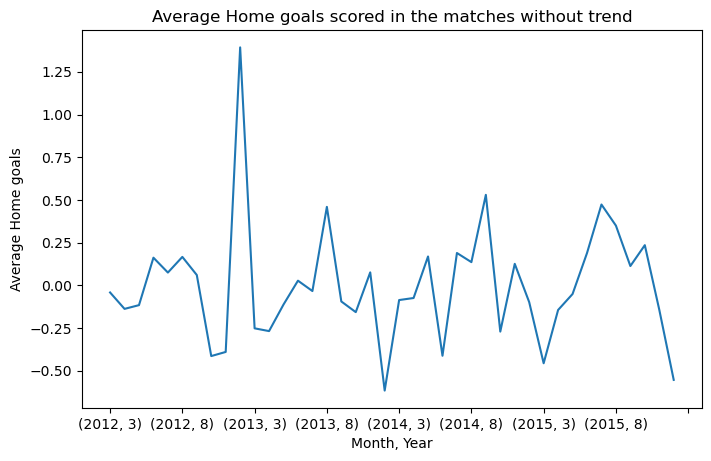

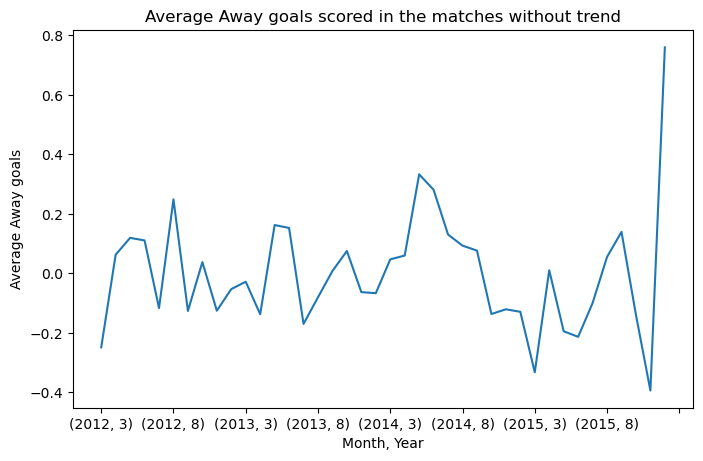

In [1934]:
# Data without trend for Home goals
xNoTrend_home = group_month_year_home - trend_home
# plt.plot(xNoTrend)
figure(figsize = (8, 5), dpi = 100)
plt.title("Average Home goals scored in the matches without trend")
xNoTrend_home.plot()
plt.xlabel("Month, Year")
plt.ylabel("Average Home goals")

# Data without trend for Away goals
xNoTrend_away = group_month_year_away - trend_away
# plt.plot(xNoTrend)
figure(figsize = (8, 5), dpi = 100)
plt.title("Average Away goals scored in the matches without trend")
xNoTrend_away.plot()
plt.xlabel("Month, Year")
plt.ylabel("Average Away goals")


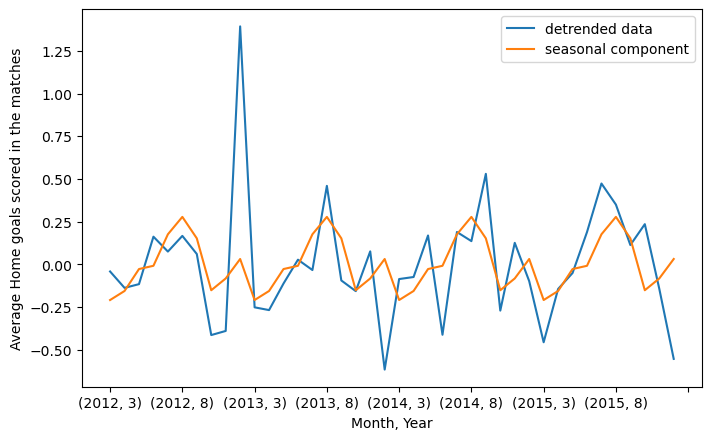

Text(0.5, 0, 'Months (March - December)')

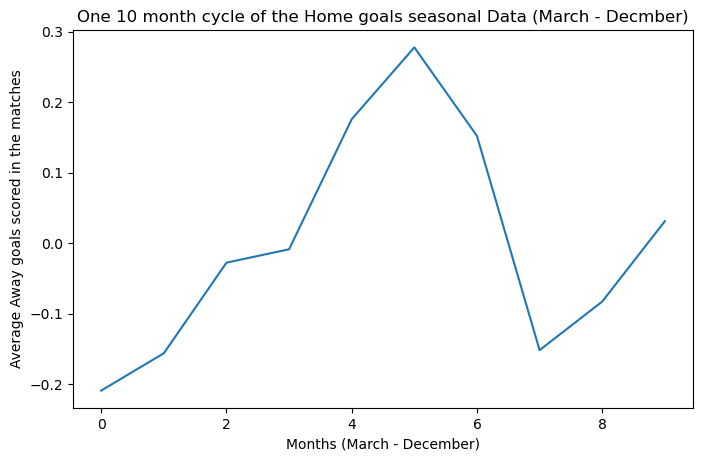

In [1937]:
z = np.array(xNoTrend_home)
wave = np.mean(z.reshape(int(z.size/10),10),axis=0)
# Finding the seasonlity in Home goals and plotting
seasonal_home = np.matlib.repmat(wave,1,4)
seasonal_home = np.transpose(seasonal_home) # this makes seasonal the same shape as x 
seasonal_home.shape

figure(figsize = (8, 5), dpi = 100)
xNoTrend_home.plot()
plt.plot(seasonal_home)
plt.legend(('detrended data','seasonal component'))
plt.ylabel("Average Home goals scored in the matches")
plt.xlabel("Month, Year")
plt.show()


figure(figsize = (8, 5), dpi = 100)
plt.title("One 10 month cycle of the Home goals seasonal Data (March - Decmber)")
plt.plot(seasonal_home[0:10])
plt.ylabel("Average Away goals scored in the matches")
plt.xlabel("Months (March - December)")

# print(seasonal_home[0:10])

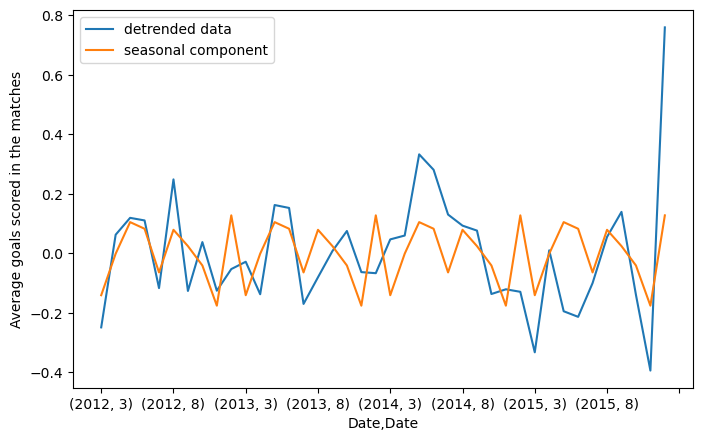

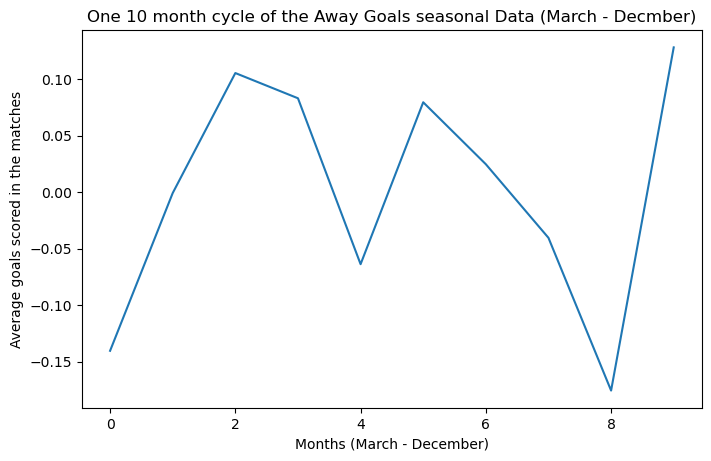

In [1865]:
# Finding the seasonlity in Away goals and plotting
z = np.array(xNoTrend_away)
wave = np.mean(z.reshape(int(z.size/10),10),axis=0)
seasonal_away = np.matlib.repmat(wave,1,4)
seasonal_away = np.transpose(seasonal_away) # this makes seasonal the same shape as x 
seasonal_away.shape

figure(figsize = (8, 5), dpi = 100)
plt.ylabel("Average goals scored in the matches")
plt.xlabel("Month, Year")
xNoTrend_away.plot()
plt.plot(seasonal_away)
plt.legend(('detrended data','seasonal component'))
plt.show()

figure(figsize = (8, 5), dpi = 100)
plt.title("One 10 month cycle of the Away Goals seasonal Data (March - Decmber)")
plt.ylabel("Average goals scored in the matches")
plt.xlabel("Months (March - December)")
plt.plot(seasonal_away[0:10])

# print(seasonal_away[0:10])

### Q3 - A simple Model

#### Q3.1 Finding the parameters of the model based on personal interpretation
These have not been used further, just calculated to check how the interpretation fits into the model

In [1520]:
home_df = fitset.groupby('Home')
away_df = fitset.groupby('Away')
df = pd.DataFrame(columns=['team','goals_scored','goals_conceded', 'matches_played'])

for team,stats in home_df:
    df.loc[len(home_df)] = [team, stats.HG.sum(), stats.AG.sum(), stats.HG.count()]
    df.index = df.index - 1

for team,stats in away_df:
    df.loc[df.team == team,'goals_scored'] = df.loc[df['team'] == team].goals_scored + stats.AG.sum()
    df.loc[df.team == team,'goals_conceded'] = df.loc[df['team'] == team].goals_conceded + stats.HG.sum()
    df.loc[df.team == team,'matches_played'] = df.loc[df['team'] == team].matches_played + stats.HG.count()

df = df.sort_index()
df['avg_scored'] = df['goals_scored']/df['matches_played']
df['avg_conceded'] = df['goals_conceded']/df['matches_played']
total_league_goals = df.goals_scored.sum()
total_league_matches = len(fitset)
# Gamma
avg_league_goals = total_league_goals/(total_league_matches*2)
# Alpha
df['attack_threat'] = df['avg_scored']/avg_league_goals
# Beta
df['defense_threat'] = df['avg_conceded']/avg_league_goals
# Eta
home_advantage = home_df.HG.sum().sum()/total_league_goals

# alphas = np.array(df.attack_threat)
# betas = np.array(df.defense_threat)
# gamma = avg_league_goals
# eta = home_advantage


In [2325]:
# Fitting the Model using the Maxmimum likelihood ~~ (minimum Log likelihood)

teams = fitset["Home"].sort_values().unique()

# initializing the parameters. Values have been improvised by Brute force to find the best local Minima
# Keeping a random seed fixed to replicate values (408 being my Birthdat in dd-mm => 04-08)
np.random.seed(408)
alpha = np.random.uniform(0,0.25,nteams)
beta = np.random.uniform(0,0.25,nteams)
gamma = np.random.uniform(0,0.25)
eta = np.random.uniform(0,0.25)
params0 = np.concatenate((alpha, beta, [gamma, eta]))
# print("initial", alpha)
# print("initial", beta)

# Model to predict output per game. This predicts the outcome and returns the same dataset with updated values.
def model_A(testset, par):
    teams = testset["Home"].sort_values().unique()
    
    for index in range(len(testset)):
        home_index = np.where(teams == testset.iloc[index].Home)[0][0]
        away_index = np.where(teams == testset.iloc[index].Away)[0][0]
        testset.loc[index, 'lambda'] =  np.exp(par["alpha"][home_index] + par["beta"][away_index] + \
                                               par["gamma"] + (par["eta"]/2))
        testset.loc[index, 'mu'] =  np.exp(par["alpha"][away_index] + par["beta"][home_index] + par["gamma"] \
                                          - (par["eta"]/2))

    for index in range(len(testset)):
        lambda_val = testset.loc[index, 'lambda']
        mu_val = testset.loc[index, 'mu']
        prob_home = 0
        prob_draw = 0
        prob_away = 0
        #goals home team will score
        for i in range(7):
            #goals away team will score
            for j in range(7):
                home_scoring_prob = poisson.pmf(k=i,mu = lambda_val)
                away_scoring_prob = poisson.pmf(k=j,mu = mu_val)
                joint_prob = home_scoring_prob * away_scoring_prob
                if (i > j):
                    prob_home = prob_home + joint_prob
                elif(j > i):
                    prob_away = prob_away + joint_prob
                else:
                    prob_draw = prob_draw + joint_prob

        testset.loc[index, 'home_win_prob'] = prob_home
        testset.loc[index, 'away_win_prob'] = prob_away
        testset.loc[index, 'draw_prob'] = prob_draw

        result_conditions = [(testset['home_win_prob'] > testset['away_win_prob']) & (testset['home_win_prob'] > testset['draw_prob']),
                  (testset['away_win_prob'] > testset['home_win_prob']) & (testset['away_win_prob'] > testset['draw_prob']),
                  (testset['draw_prob'] > testset['home_win_prob']) & (testset['draw_prob'] > testset['away_win_prob'])]
        testset['predicted_result'] = np.select(result_conditions, ['H', 'A', 'D'])
        
    return testset

# Training the model using an objective/log-likelihood function
def train_A(par0, fitset):
    teams = fitset["Home"].sort_values().unique()
    nteams = len(teams)
    bounds = [(0, None)]*nteams*2 + [(0, None), (0, None)]
    results = minimize(poisson_loglike, par0, args=(fitset, teams), method ='L-BFGS-B', bounds=bounds)
    
    alpha_hat = results.x[:nteams]
    beta_hat = results.x[nteams:(2*nteams)]
    gamma_hat = results.x[(2*nteams)]
    eta_hat = results.x[(2*nteams+1)]
#     Return the optimised parameters along with likelihood value
    return {'alpha': alpha_hat, 'beta': beta_hat, 'gamma': gamma_hat, 'eta': eta_hat}, -results.fun
   
# Likelihood Function to train the model parameters.
def poisson_loglike(params, fitset, teams):
    alpha = params[:nteams]
    beta = params[nteams:(2*nteams)]
    gamma = params[(2*nteams)]
    eta = params[(2*nteams+1)]
    loglike = 0
    for i in range(len(fitset)):
        home_index = np.where(teams == fitset.iloc[i].Home)[0][0]
        away_index = np.where(teams == fitset.iloc[i].Away)[0][0]
        lambda_vals = np.exp(alpha[home_index] + beta[away_index] + gamma + eta/2)
        mu_vals = np.exp(alpha[away_index] + beta[home_index] + gamma - eta/2)
#         loglike value is based on the reference in Dixon-Coles paper suggesting it to be Π e^-λ*λ^Xk * e^-µ*µ^Yk
#         Also has been converted to summation by taking log values and minimising the function
        loglike = loglike + ((-lambda_vals) + (fitset.iloc[i].HG * np.log(lambda_vals)) + (-mu_vals) + (fitset.iloc[i].AG*np.log(mu_vals)))
#     print(-np.round(loglike,4))
    return -np.round(loglike,4)

par, likelihood = train_A(params0, fitset)


In [2326]:
print("Estimated alpha values:")
print(par["alpha"])
print("Estimated beta values:")
print(par["beta"])
print("Estimated gamma value:")
print(par["gamma"])
print("Estimated eta value:")
print(par["eta"])
print("Final log-likelihood:")
print(-likelihood)

Estimated alpha values:
[0.12341106 0.20802457 0.24675675 0.12172958 0.10140116 0.06722072
 0.22706395 0.22189534 0.00196502 0.11603018 0.18484321 0.04277269
 0.15187254 0.1130817  0.07879463 0.15212231 0.04626327 0.08962385
 0.10613005 0.17943074 0.15085034]
Estimated beta values:
[0.0602658  0.21420261 0.10096183 0.03742627 0.21802281 0.17954881
 0.03686895 0.04000483 0.23299735 0.19105481 0.18113644 0.14776924
 0.17542071 0.0691458  0.12165789 0.10660014 0.03056413 0.11336527
 0.20876228 0.22419225 0.00169962]
Estimated gamma value:
0.047871813486816045
Estimated eta value:
0.24446569459797093
Final log-likelihood:
2563.9825


### Section 4.4

One way to fit a new model that takes the seasonal component into account is using ARIMA models to find the autoregressive and Moving average components. 

A simlper way in the current case is to use a seasonal variable within our data. Given the Seasonality above, We can see that the months of March, April October and November have significantly lower goals than the average, while August and september have higher than average goals and May June and July have no shift from the average. 

Hence a variable that gets subtracted in the low scoring months from our equation and gets added in the high scoring months. 

We will introduce a variable called seasonal having values of {-1, 0, 1} denoting lower, average and higher vales respectively. This variable will now contribute towards the estimation of our parameters.

In [2328]:
fitset_b = fitset.copy(deep = True)
fitset_b = fitset_b.reset_index(drop=True)
fitset_b['month'] = pd.DatetimeIndex(fitset_b['Date']).month
# Adding seasonal columns
fitset_b['seasonal'] = 0
seasonal_conditions = [(fitset_b['month'].isin([8,9])), (fitset_b['month'].isin([3,4,10,11]))]
fitset_b['seasonal'] = np.select(seasonal_conditions,[1, -1])

np.random.seed(408)
alpha = np.random.uniform(0,0.25,nteams)
beta = np.random.uniform(0,0.25,nteams)
gamma = np.random.uniform(0,0.25)
eta = np.random.uniform(0,0.25)
season_param = np.random.uniform(0,0.25)
params0 = np.concatenate((alpha, beta, [gamma, eta, season_param]))

def model_B(testset, par_b):
    teams = testset["Home"].sort_values().unique()
    
    for index in range(len(testset)):
        home_index = np.where(teams == testset.iloc[index].Home)[0][0]
        away_index = np.where(teams == testset.iloc[index].Away)[0][0]
        testset.loc[index, 'lambda'] =  np.exp(par_b["alpha"][home_index] + par_b["beta"][away_index] + \
                                               par_b["gamma"] + (par_b["eta"]/2) + \
                                               fitset_b.iloc[index].seasonal*par_b['season'])
        testset.loc[index, 'mu'] =  np.exp(par_b["alpha"][away_index] + par_b["beta"][home_index] + par_b["gamma"] - (par_b["eta"]/2) + testset.iloc[index].seasonal*par_b['season'])


    for index in range(len(testset)):
        lambda_val = testset.loc[index, 'lambda']
        mu_val = testset.loc[index, 'mu']
        prob_home = 0
        prob_draw = 0
        prob_away = 0
        #goals home team will score
        for i in range(7):
            #goals away team will score
            for j in range(7):
                home_scoring_prob = poisson.pmf(k=i,mu = lambda_val)
                away_scoring_prob = poisson.pmf(k=j,mu = mu_val)
                joint_prob = home_scoring_prob * away_scoring_prob
                if (i > j):
                    prob_home = prob_home + joint_prob
                elif(j > i):
                    prob_away = prob_away + joint_prob
                else:
                    prob_draw = prob_draw + joint_prob

        testset.loc[index, 'home_win_prob'] = prob_home
        testset.loc[index, 'away_win_prob'] = prob_away
        testset.loc[index, 'draw_prob'] = prob_draw

        result_conditions = [(testset['home_win_prob'] > testset['away_win_prob']) & (testset['home_win_prob'] > testset['draw_prob']),
                  (testset['away_win_prob'] > testset['home_win_prob']) & (testset['away_win_prob'] > testset['draw_prob']),
                  (testset['draw_prob'] > testset['home_win_prob']) & (testset['draw_prob'] > testset['away_win_prob'])]
        testset['predicted_result'] = np.select(result_conditions, ['H', 'A', 'D'])
        
    return testset


def train_B(par0, fitset_b):
    teams = fitset_b["Home"].sort_values().unique()
    nteams = len(teams)
    bounds = [(0, None)]*nteams*2 + [(0, None), (0, None), (0, None)]
    results = minimize(poisson_loglike_B, par0, args=(fitset_b, teams), method ='L-BFGS-B', bounds=bounds)
    
    alpha_hat = results.x[:nteams]
    beta_hat = results.x[nteams:(2*nteams)]
    gamma_hat = results.x[(2*nteams)]
    eta_hat = results.x[(2*nteams+1)]
    season_hat = results.x[(2*nteams+2)]
#     Return the optimised parameters along with likelihood value
    return {'alpha': alpha_hat, 'beta': beta_hat, 'gamma': gamma_hat, 'eta': eta_hat, 'season': season_hat}, -results.fun
   
# Likelihood Function to train the model parameters.
def poisson_loglike_B(params, fitset_b, teams):
    alpha = params[:nteams]
    beta = params[nteams:(2*nteams)]
    gamma = params[(2*nteams)]
    eta = params[(2*nteams+1)]
    season_param = params[(2*nteams+2)]
    loglike = 0
    for i in range(len(fitset)):
        home_index = np.where(teams == fitset_b.iloc[i].Home)[0][0]
        away_index = np.where(teams == fitset_b.iloc[i].Away)[0][0]
        lambda_vals = np.exp(alpha[home_index] + beta[away_index] + gamma + eta/2 + fitset_b.iloc[i].seasonal*season_param)
        mu_vals = np.exp(alpha[away_index] + beta[home_index] + gamma - eta/2 + fitset_b.iloc[i].seasonal*season_param)
#         loglike value is based on the reference in Dixon-Coles paper suggesting it to be Π e^-λ*λ^Xk * e^-µ*µ^Yk
#         Also has been converted to summation by taking log values and minimising the function
        loglike = loglike + ((-lambda_vals) + (fitset_b.iloc[i].HG * np.log(lambda_vals)) + (-mu_vals) + (fitset_b.iloc[i].AG*np.log(mu_vals)))
#     print(-np.round(loglike,4))
    return -np.round(loglike,4)

par_b, likelihood_b = train_B(params0, fitset_b)



In [2329]:
print("Parameters for Model B:")
print("Estimated alpha values:")
print(par_b["alpha"])
print("Estimated beta values:")
print(par_b["beta"])
print("Estimated gamma value:")
print(par_b["gamma"])
print("Estimated eta value:")
print(par_b["eta"])
print("Estimated season value:")
print(par_b["season"])
print("Final log-likelihood:")
print(-likelihood_b)

Parameters for Model B:
Estimated alpha values:
[0.12341106 0.20802457 0.24675675 0.12172958 0.10140116 0.06722072
 0.22706395 0.22189534 0.00196502 0.11603018 0.18484321 0.04277269
 0.15187254 0.1130817  0.07879463 0.15212231 0.04626327 0.08962385
 0.10613005 0.17943074 0.15085034]
Estimated beta values:
[0.0602658  0.21420261 0.10096183 0.03742627 0.21802281 0.17954881
 0.03686895 0.04000483 0.23299735 0.19105481 0.18113644 0.14776924
 0.17542071 0.0691458  0.12165789 0.10660014 0.03056413 0.11336527
 0.20876228 0.22419225 0.00169962]
Estimated gamma value:
0.047871813486816045
Estimated eta value:
0.24446569459797093
Estimated season value:
0.09846477863243883
Final log-likelihood:
2554.4505


In [2332]:
fitset.loc[:,"lambda"] = 0
fitset.loc[:,"mu"] = 0
fitset.loc[:,"home_win_prob"] = 0
fitset.loc[:,"draw_prob"] = 0
fitset.loc[:,"away_win_prob"] = 0
fitset.loc[:,"predicted_result"] = 0
fitset.loc[:,"predicted_home_points"] = 0
fitset.loc[:,"predicted_away_points"] = 0
fitset = fitset.reset_index(drop=True)

fitset_b.loc[:,"lambda"] = 0
fitset_b.loc[:,"mu"] = 0
fitset_b.loc[:,"home_win_prob"] = 0
fitset_b.loc[:,"draw_prob"] = 0
fitset_b.loc[:,"away_win_prob"] = 0
fitset_b.loc[:,"predicted_result"] = 0
fitset_b.loc[:,"predicted_home_points"] = 0
fitset_b.loc[:,"predicted_away_points"] = 0
fitset_b = fitset_b.reset_index(drop=True)

In [2338]:
# Predicting the results using Model A and B to check efficiancy on the fitset
fitset_b = model_B(fitset_b, par_b)
fitset = model_A(fitset, par)


We check the performance of the 2 models on the training or fitset

In [2346]:
print("The correct results predicted by Model B on fitset are:", np.sum(fitset_b['Res'] == fitset_b['predicted_result']), "or ", np.sum(fitset_b['Res'] == fitset_b['predicted_result'])/len(fitset_b))
print("The correct results predicted by Model A on fitset are:", np.sum(fitset['Res'] == fitset['predicted_result']), "or ", np.sum(fitset['Res'] == fitset['predicted_result'])/len(fitset_b))


The correct results predicted by Model B on fitset are: 670 or  0.4886943836615609
The correct results predicted by Model A on fitset are: 670 or  0.4886943836615609


Both the models behave the same which means that the seasonality factor has no impact on the result of model B.

Hence we will be using model A as our best model

### Section 5 - Forecasting

##### 5.1 and 5.2 
Creating a deep copy of Simset to make modification to the table rather than the view

In [2354]:
simset.loc[:,"lambda"] = 0
simset.loc[:,"mu"] = 0
simset.loc[:,"home_win_prob"] = 0
simset.loc[:,"draw_prob"] = 0
simset.loc[:,"away_win_prob"] = 0
simset.loc[:,"predicted_result"] = 0
simset.loc[:,"predicted_home_points"] = 0
simset.loc[:,"predicted_away_points"] = 0
testset = simset.copy(deep=True)
testset = testset.reset_index(drop=True)

Computing the Lambda and Mu values along with Home win, Away Win and Draw Probabilities

In [2355]:
# teams = fitset["Home"].sort_values().unique()
# # Computing lambda and Mu
# for index in range(len(testset)):
#     home_index = np.where(teams == testset.iloc[index].Home)[0][0]
#     away_index = np.where(teams == testset.iloc[index].Away)[0][0]
#     testset.loc[index, 'lambda'] =  np.exp(par["alpha"][home_index] + par["beta"][away_index] + par["gamma"] + (par["eta"]/2))
#     testset.loc[index, 'mu'] =  np.exp(par["alpha"][away_index] + par["beta"][home_index] + par["gamma"] - (par["eta"]/2))

simulation2016 = testset.copy(deep=True)
simulation2016 = simulation2016.reset_index(drop=True)

# Computing the result by calling the model
testset = model_A(testset, par)


##### 5.3 
Computing the league table based on Highest probabilities after assigning points to each game

In [2356]:
# Computing points based on reults
home_conditions = [(testset['home_win_prob'] > testset['away_win_prob']) & (testset['home_win_prob'] > testset['draw_prob']),
              (testset['draw_prob'] > testset['home_win_prob']) & (testset['draw_prob'] > testset['away_win_prob'])]

away_conditions = [(testset['away_win_prob'] > testset['home_win_prob']) & (testset['away_win_prob'] > testset['draw_prob']),
              (testset['draw_prob'] > testset['home_win_prob']) & (testset['draw_prob'] > testset['away_win_prob'])]


testset['predicted_home_points'] = np.select(home_conditions,[3, 1])
testset['predicted_away_points'] = np.select(away_conditions,[3, 1])

# Creating League Table and adding points from all games
leagueTable = pd.DataFrame(columns=['team','points'])
leagueTable['team'] = testset["Home"].sort_values().unique()
leagueTable = pd.merge(leagueTable, testset.groupby('Home').predicted_home_points.sum(), left_on='team', right_on='Home')
leagueTable = pd.merge(leagueTable, testset.groupby('Away').predicted_away_points.sum(), left_on='team', right_on='Away')
leagueTable['points'] = leagueTable['predicted_home_points'] + leagueTable['predicted_away_points']  
leagueTable = leagueTable.sort_values(by='points', ascending=False)
print(leagueTable)


,team,points,predicted_home_points,predicted_away_points
2,Colorado Rapids,60,51,9
7,Los Angeles Galaxy,60,51,9
3,Columbus Crew,57,51,6
6,Houston Dynamo,57,51,6
0,CF Montreal,54,51,3
16,Seattle Sounders,54,51,3
13,Portland Timbers,54,51,3
12,Philadelphia Union,51,51,0
17,Sporting Kansas City,51,51,0
15,San Jose Earthquakes,51,51,0


##### 5.4
Reading Simset and comparing performance of the 2 models

In [2358]:
# data_mls_simset_predictions
simset_predictions = pd.read_csv("data_mls_simset_predictions.csv")
simset_predictions['Date'] = pd.to_datetime(simset_predictions['Date'], format="%Y/%m/%d")
simset_predictions['Home'] = simset_predictions['Home'].replace(['Montreal Impact'], 'CF Montreal')
simset_predictions['Away'] = simset_predictions['Away'].replace(['Montreal Impact'], 'CF Montreal')

# Merging Actual results of 2016 season into Simset Prediction File
simset_predictions = pd.merge(simset_predictions, testset[['Home', 'Away', 'Date', 'HG', 'AG', 'Res']],
                   left_on=['Home', 'Away', 'Date'], right_on=['Home', 'Away', 'Date'])

result_conditions = [(simset_predictions['expected_team1_win'] > simset_predictions['expected_team2_win']) & (simset_predictions['expected_team1_win'] > simset_predictions['expected_draw']),
              (simset_predictions['expected_team2_win'] > simset_predictions['expected_team1_win']) & (simset_predictions['expected_team2_win'] > simset_predictions['expected_draw']),
              (simset_predictions['expected_draw'] > simset_predictions['expected_team1_win']) & (simset_predictions['expected_draw'] > simset_predictions['expected_team2_win'])]

simset_predictions['predicted_result'] = np.select(result_conditions, ['H', 'A', 'D'])

home_conditions = [(simset_predictions['expected_team1_win'] > simset_predictions['expected_team2_win']) & (simset_predictions['expected_team1_win'] > simset_predictions['expected_draw']),
              (simset_predictions['expected_draw'] > simset_predictions['expected_team1_win']) & (simset_predictions['expected_draw'] > simset_predictions['expected_team2_win'])]

away_conditions = [(simset_predictions['expected_team2_win'] > simset_predictions['expected_team1_win']) & (simset_predictions['expected_team2_win'] > simset_predictions['expected_draw']),
              (simset_predictions['expected_draw'] > simset_predictions['expected_team1_win']) & (simset_predictions['expected_draw'] > simset_predictions['expected_team2_win'])]

simset_predictions['predicted_home_points'] = np.select(home_conditions,[3, 1])
simset_predictions['predicted_away_points'] = np.select(away_conditions,[3, 1])


In [2360]:
def ER(data):
    # compute the error rate
    ER=(data['predicted_result'] == data['Res']).sum()
    return ER

print("Out of 340 total matches in 2016, the results between Model C and Model A are below")
print("The number of correct predictions in the simset, Model C are:", ER(simset_predictions))
print("The number of correct predictions in the testset, model A are:", ER(testset))
print("\n")
print("The difference in Expected goals and Actual Goals throughout the year, the results between Model C and Model A are below")
print("Actual number of Goals in the 2016 season:", testset['HG'].sum() + testset['AG'].sum())
print("the difference between predicted and actual Goals for Model C are:",simset_predictions['expected_team1_goals'].sum() \
      + simset_predictions['expected_team2_goals'].sum() -  simset_predictions['HG'].sum() - simset_predictions['AG'].sum())

print("the difference between predicted and actual Goals for Model A are:",testset['lambda'].sum() + testset['mu'].sum() \
      -  testset['HG'].sum() - testset['AG'].sum())



Out of 340 total matches in 2016, the results between Model C and Model A are below
The number of correct predictions in the simset, Model C are: 168
The number of correct predictions in the testset, model A are: 164


The difference in Expected goals and Actual Goals throughout the year, the results between Model C and Model A are below
Actual number of Goals in the 2016 season: 956
the difference between predicted and actual Goals for Model C are: -10.576685654335847
the difference between predicted and actual Goals for Model A are: -16.490989355183956


### Section 6 - Simulation

#### 6.1

In [2023]:
simulation2016.loc[:,"predicted_HG"] = 0
simulation2016.loc[:,"predicted_AG"] = 0
simulation2016.loc[:,"predicted_result"] = 0
simulation2016.loc[:,"predicted_home_points"] = 0
simulation2016.loc[:,"predicted_away_points"] = 0

In [2145]:
# function to simulate the season
# np.random.seed(408)
def simulate_league_table(simulation2016):
    
    for index in range(len(simulation2016)):
        home_goals = np.random.poisson(simulation2016.iloc[index]['lambda'], 1)
        away_goals = np.random.poisson(simulation2016.iloc[index]['mu'], 1)
    #     result = 
        if(home_goals > away_goals):
            result = 'H'
        elif(away_goals > home_goals):
            result = 'A'
        else:
            result = 'D'

        simulation2016.at[index,'predicted_HG'] = home_goals
        simulation2016.at[index,'predicted_AG'] = away_goals
        simulation2016.at[index,'predicted_result'] = result


    # Computing points based on reults
    sim_home_conditions = [(simulation2016['predicted_result'] =='H'),
                  (simulation2016['predicted_result'] == 'D')]

    sim_away_conditions = [(simulation2016['predicted_result'] =='A'),
                  (simulation2016['predicted_result'] == 'D')]


    simulation2016['predicted_home_points'] = np.select(sim_home_conditions,[3, 1])
    simulation2016['predicted_away_points'] = np.select(sim_away_conditions,[3, 1])
    
    leagueTable_sim = create_league_table(simulation2016)
    
    return leagueTable_sim

In [2146]:
# Simmed league Table
def create_league_table(simulation2016):
    leagueTable_sim = pd.DataFrame(columns=['team','points', 'GF', 'GA', 'GD'])
    leagueTable_sim['team'] = simulation2016["Home"].sort_values().unique()

    leagueTable_sim = pd.merge(leagueTable_sim, \
                               simulation2016.groupby('Home').agg({'predicted_home_points':sum, 'predicted_HG': sum, \
                                                                   'predicted_AG':sum}), left_on='team', right_on='Home')
    # Adding Home points and Home GF , GA
    leagueTable_sim['points'] = leagueTable_sim['predicted_home_points']
    leagueTable_sim['GF'] = leagueTable_sim['predicted_HG']
    leagueTable_sim['GA'] = leagueTable_sim['predicted_AG']
    leagueTable_sim = leagueTable_sim.drop(columns=['predicted_HG', 'predicted_AG'])

    # Adding Away points and Away GF , GA
    leagueTable_sim = pd.merge(leagueTable_sim, \
                               simulation2016.groupby('Away').agg({'predicted_away_points':sum, 'predicted_HG': sum, \
                                                                   'predicted_AG':sum}), left_on='team', right_on='Away')

    leagueTable_sim['points'] = leagueTable_sim['points'] + leagueTable_sim['predicted_away_points']
    leagueTable_sim['GF'] = leagueTable_sim['GF'] + leagueTable_sim['predicted_AG']
    leagueTable_sim['GA'] = leagueTable_sim['GA'] + leagueTable_sim['predicted_HG']
    leagueTable_sim = leagueTable_sim.drop(columns=['predicted_HG', 'predicted_AG'])
    leagueTable_sim['GD'] = leagueTable_sim['GF'] - leagueTable_sim['GA']

    # Merging the table with conference dataFrame used in section 1
    leagueTable_sim = pd.merge(leagueTable_sim, conference[['Team', 'Conference']], left_on='team', right_on='Team')
    leagueTable_sim = leagueTable_sim.drop(columns=['Team'])
    
    return leagueTable_sim

# Creating Conference wise Table
def create_conferences(leagueTable_sim):
    eastern_table = leagueTable_sim[leagueTable_sim['Conference'] == 'Eastern'].sort_values(by=['points', 'GD', 'GF', 'team'], ascending =  [False, False,False,True])
    western_table = leagueTable_sim[leagueTable_sim['Conference'] == 'Western'].sort_values(by=['points', 'GD', 'GF', 'team'], ascending =  [False, False,False,True])

    return eastern_table, western_table



In [2184]:
# Simulating league once
leagueTable_sim = simulate_league_table(simulation2016)
# Creating seperate league tables
eastern_table, western_table = create_conferences(leagueTable_sim)

In [2185]:
eastern_table

,team,points,GF,GA,GD,predicted_home_points,predicted_away_points,Conference
1,Chicago Fire,56,56.0,53.0,3.0,39,17,Eastern
11,Orlando City,54,46.0,39.0,7.0,36,18,Eastern
9,New York City,51,55.0,51.0,4.0,26,25,Eastern
3,Columbus Crew,46,44.0,43.0,1.0,25,21,Eastern
0,CF Montreal,44,45.0,48.0,-3.0,28,16,Eastern
12,Philadelphia Union,44,44.0,47.0,-3.0,26,18,Eastern
18,Toronto FC,43,40.0,44.0,-4.0,27,16,Eastern
8,New England Revolution,43,46.0,51.0,-5.0,19,24,Eastern
10,New York Red Bulls,41,39.0,47.0,-8.0,17,24,Eastern
4,DC United,36,39.0,52.0,-13.0,24,12,Eastern


In [2186]:
western_table

,team,points,GF,GA,GD,predicted_home_points,predicted_away_points,Conference
14,Real Salt Lake,67,48.0,33.0,15.0,37,30,Western
6,Houston Dynamo,55,46.0,42.0,4.0,37,18,Western
2,Colorado Rapids,52,44.0,40.0,4.0,29,23,Western
19,Vancouver Whitecaps,51,40.0,32.0,8.0,25,26,Western
5,FC Dallas,49,46.0,37.0,9.0,29,20,Western
16,Seattle Sounders,43,46.0,44.0,2.0,26,17,Western
17,Sporting Kansas City,42,44.0,48.0,-4.0,24,18,Western
7,Los Angeles Galaxy,41,43.0,49.0,-6.0,18,23,Western
15,San Jose Earthquakes,40,44.0,54.0,-10.0,25,15,Western
13,Portland Timbers,35,43.0,44.0,-1.0,20,15,Western


#### 6.2 - Simulating 10000 times

In [2188]:
la_galaxy_count = 0
for i in range(10000):
    leagueTable_sim = simulate_league_table(simulation2016)
    eastern_table, western_table = create_conferences(leagueTable_sim)
    la_galaxy_count = la_galaxy_count + western_table.head(2).team.isin(["Los Angeles Galaxy"]).sum()

In [2195]:
probability_la = la_galaxy_count/10000
print("The probability that LA Galaxy finish in the top 2 in their conference is :", probability_la)

The probability that LA Galaxy finish in the top 2 in their conference is : 0.0192


#### 6.3 Monte Carlo Simulation 

In [2362]:
# standard error of the mean
se_p = np.sqrt((probability_la*(1-probability_la))/10000)
# 95% CI means alpha of 5%
alpha = 0.05
z_val_la = stats.norm.ppf(1-alpha/2)

# compute and print confidence interval
ci_la = p + z_val_la*se_p*np.array([-1,1])
print('The 95% Confidence Interval of LA galaxy finishing in top 2 is: ', str(ci_la))
epsilon = 0.001

number_sim = ((z_val_la**2)*probability_la*(1-probability_la))/(epsilon**2)
# number_sim = (((z_val_la)*np.sqrt(probability_la*(1-probability_la)))/(epsilon))**2
# (z_val_la**2)*probability_la*(1-probability_la)
print("Number of Simulations needed for Monte Carlo error of 0.1% is:", np.ceil(number_sim))

The 95% Confidence Interval of LA galaxy finishing in top 2 is:  [0.01651039 0.02188961]
Number of Simulations needed for Monte Carlo error of 0.1% is: 72340.0
